<a href="https://colab.research.google.com/github/parham/thermal-segmentor/blob/develop/wonjik2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering 

#### **Journal** : IEEE Transactions on Image Processing
#### **Year** : 2020
#### **Repository** : https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip
#### **Citation** : Wonjik Kim*, Asako Kanezaki*, and Masayuki Tanaka. Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering. IEEE Transactions on Image Processing, accepted, 2020.

#### Parham Nooralishahi - parham.nooralishahi.1@ulaval.ca
#### Supervisor : Professor Xavier Maldague
#### Organization : Université Laval

---------------------



In [1]:
#@title Install Requirements
#@markdown Installing python packages.

# !pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl --force-reinstall 
# !pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl --force-reinstall 

# Install packages
!pip install pytorch-ignite torchmetrics comet-ml opencv-python scikit-image scikit-learn dotmap



     |████████████████████████████████| 251 kB 28.5 MB/s 
     |████████████████████████████████| 398 kB 63.0 MB/s 
     |████████████████████████████████| 342 kB 69.3 MB/s 
     |████████████████████████████████| 551 kB 71.5 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-py3-none-any.whl size=34547 sha256=2ee847cf56c739be33fce98eb73f55429a2518cb79f246edfbfa4108f456856a
  Stored in directory: /root/.cache/pip/wheels/0d/c4/19/13d74440f2a571841db6b6e0a273694327498884dafb9cf978
Successfully built configobj


In [2]:
#@title Mounting Google Drive
#@markdown Mounting the google drive to the colab env.

import os
from google.colab import drive

dataset_path = '/content/drive/My Drive/Datasets/my-dataset/thermal-segmentor/Aerospace_Inspection' #@param {type: "string"}  

dataset_name = 'Aerospace_Inspection' #@param {type: "string"}  

print(dataset_name)

drive.mount('/content/drive', force_remount=True)


Aerospace_Inspection
Mounted at /content/drive


In [3]:
#@title Configuring the workspace
#@markdown The initialization of variables.

img_dataset_path = os.path.join(dataset_path, 'img') 
target_dataset_path = os.path.join(dataset_path, 'target') 
result_dataset_path = os.path.join(dataset_path, 'result') 

print(f'Image Dataset Path : {img_dataset_path}')
print(f'Target Dataset Path : {target_dataset_path}')
print(f'Result Dataset Path : {result_dataset_path}')

!mkdir -p "{result_dataset_path}"

Image Dataset Path : /content/drive/My Drive/Datasets/my-dataset/thermal-segmentor/Aerospace_Inspection/img
Target Dataset Path : /content/drive/My Drive/Datasets/my-dataset/thermal-segmentor/Aerospace_Inspection/target
Result Dataset Path : /content/drive/My Drive/Datasets/my-dataset/thermal-segmentor/Aerospace_Inspection/result


In [4]:
#@title Configure Comet.ml engine

api_key = '8CuCMLyaa23fZDEY2uTxm5THf' #@param {type: "string"} 
project_name = 'thermal-segmentor'
workspace = 'parham'

In [5]:
#@title Load Configuration
#@markdown Loading json entity containing the configuration.

import json
from IPython.display import HTML
from dotmap import DotMap

def render(jstr):
  if type(jstr) != str:
    jstr = json.dumps(jstr)
  return HTML("""
    <script src="https://rawgit.com/caldwell/renderjson/master/renderjson.js"></script>
    <script>
    renderjson.set_show_to_level(1)
    document.body.appendChild(renderjson(%s))
    new ResizeObserver(google.colab.output.resizeIframeToContent).observe(document.body)
    </script>""" % jstr)

config_str = """ 
{
    "model" : {
        "num_channels" : 100,
        "num_conv_layers" : 6
    },
    "segmentation": {
        "iteration" : 200,
        "similarity_loss" : 1,
        "continuity_loss" : 0.5,
        "learning_rate" : 0.1,
        "momentum" : 0.9,
        "min_classes" : 3
    },
    "general" : {
        "log_image" : true,
        "log_metrics" : true
    }
}
"""
config = DotMap(json.loads(config_str))
render(config_str)

In [6]:
#@title core.py
#@markdown The core components used in the script.

""" 
    @name core.py   
    @info   core.py provides common codes and imports that can be used in the project
    @organization: Laval University
    @professor  Professor Xavier Maldague
    @author     Parham Nooralishahi
    @email      parham.nooralishahi@gmail.com
"""

import os
import abc
from torchmetrics import Metric
import yaml
import json
import logging
import logging.config
import functools

from ctypes import Union
from typing import Any, Dict, List, Tuple

from time import time
from dotmap import DotMap
from comet_ml import Experiment

def initialize_log():
    """Initialize the log configuration"""
    def _init_impl(log_cfile):
        if os.path.isfile(log_cfile):
            with open(log_cfile, 'r') as f:
                config = yaml.safe_load(f.read())
                logging.config.dictConfig(config)
                logging.getLogger().setLevel(logging.INFO)
            logging.info(
                'Logging is configured based on the defined configuration file.')
        else:
            logging.error('the logging configuration file does not exist')

    _init_impl('log_config.yml')

def exception_logger(function):
    """
    A decorator that wraps the passed in function and logs 
    exceptions should one occur
    """
    @functools.wraps(function)
    def wrapper(*args, **kwargs):
        try:
            return function(*args, **kwargs)
        except:
            # log the exception
            err = "There was an exception in  " + function.__name__
            logging.exception(err)
            # re-raise the exception
            raise
    return wrapper

def running_time(func):
    def wrapper(*args, **kwargs):
        t = time.time()
        res = func(*args, **kwargs)
        runtime = time.time() - t
        res = res + (runtime, ) if isinstance(res,tuple) or \
            isinstance(res,list) else (res, runtime)
        return res
    return wrapper

@exception_logger
def load_config(config_file, dotflag : bool = True):
    config = dict()
    with open(config_file, 'r') as cfile:
        config = json.load(cfile)
    return DotMap(config) if dotflag else config

@exception_logger
def save_config(config, config_file):
    cnf = config.toDict() if isinstance(config, DotMap) else config
    with open(config_file, 'w') as cfile:
        json.dump(cnf, cfile)

class Segmentor(abc.ABC):
    def __init__(self,
        experiment : Experiment = None) -> None:
        self.experiment = experiment

    @abc.abstractmethod
    def segment_noref(self, img,
        log_img: bool = True,
        log_metrics: bool = True):
        return

    def segment(self, img,
        loop_metrics : Dict[str,Metric] = None,
        log_img: bool = True,
        log_metrics: bool = True):
        return



In [7]:
#@title wonjik2020.py
#@markdown Implementation of the method presented in Wonjik2020

import functools
import logging
from typing import Dict, Tuple
from comet_ml import Experiment
from dotmap import DotMap
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim
import torch.nn.functional as F

from torchmetrics import Metric
from ignite.engine import Engine

import time
import numpy as np

class Wonjik2020Module (nn.Module):
    """ Implementation of the model presented in:
    @name           Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering   
    @journal        IEEE Transactions on Image Processing
    @year           2020
    @repo           https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip
    @citation       Wonjik Kim*, Asako Kanezaki*, and Masayuki Tanaka. Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering. IEEE Transactions on Image Processing, accepted, 2020.
    """

    def __init__(self, num_dim, num_channels: int = 100, num_convs: int = 3):
        super(Wonjik2020Module, self).__init__()

        self.num_convs = num_convs
        self.num_channel = num_channels

        # First convolutional layer
        self.conv1 = nn.Conv2d(num_dim, self.num_channel,
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.num_channel)
        # Feature space including multiple convolutional layers
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        # The number of convolutional layers are determined based on "nCov" parameters.
        for i in range(self.num_convs-1):
            tmpConv = nn.Conv2d(
                self.num_channel, self.num_channel,
                kernel_size=3, stride=1, padding=1)
            tmpBatch = nn.BatchNorm2d(self.num_channel)
            self.conv2.append(tmpConv)
            self.bn2.append(tmpBatch)
        # The reference normalization for extracting class labels
        self.conv3 = nn.Conv2d(
            self.num_channel, self.num_channel, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(self.num_channel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        for i in range(self.num_convs-1):
            x = self.conv2[i](x)
            x = F.relu(x)
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

class Wonjik2020Loss(nn.Module):
    """ Loss function implemented based on the loss function defined in,
    @name           Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering   
    @journal        IEEE Transactions on Image Processing
    @year           2020
    @repo           https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip
    @citation       Wonjik Kim*, Asako Kanezaki*, and Masayuki Tanaka. Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering. IEEE Transactions on Image Processing, accepted, 2020.
    """

    def __init__(self,
                 num_channel: int = 100,
                 similarity_loss: float = 1.0,
                 continuity_loss: float = 0.5
                 ) -> None:
        super().__init__()
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.loss_hpy = torch.nn.L1Loss(size_average=True)
        self.loss_hpz = torch.nn.L1Loss(size_average=True)
        self.HPy_target = None
        self.HPz_target = None

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.similarity_loss = similarity_loss
        self.continuity_loss = continuity_loss
        self.nChannel = num_channel

    def set_ref(self, ref):
        self._ref = ref
        img_w = ref.shape[0]
        img_h = ref.shape[1]
        self.HPy_target = torch.zeros(
            img_w - 1, img_h, self.nChannel).to(self.device)
        self.HPz_target = torch.zeros(
            img_w, img_h - 1, self.nChannel).to(self.device)

    def forward(self, output, target, img_size: Tuple[int, int, int]):
        img_w = img_size[0]
        img_h = img_size[1]

        outputHP = output.reshape((img_w, img_h, self.nChannel))
        HPy = outputHP[1:, :, :] - outputHP[0:-1, :, :]
        HPz = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]
        lhpy = self.loss_hpy(HPy, self.HPy_target)
        lhpz = self.loss_hpz(HPz, self.HPz_target)
        # loss calculation
        return self.similarity_loss * self.loss_fn(output, target) + \
            self.continuity_loss * (lhpy + lhpz)

class Wonjik2020_Impl(Segmentor):
    """ Implementation of unsupervised segmentation method presented in,
    @name           Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering   
    @journal        IEEE Transactions on Image Processing
    @year           2020
    @repo           https://github.com/kanezaki/pytorch-unsupervised-segmentation-tip
    @citation       Wonjik Kim*, Asako Kanezaki*, and Masayuki Tanaka. Unsupervised Learning of Image Segmentation Based on Differentiable Feature Clustering. IEEE Transactions on Image Processing, accepted, 2020.
    """

    def __init__(self,
                 model,
                 optimizer,
                 loss,
                 num_channel: int = 100,
                 iteration: int = 100,
                 min_classes: int = 10,
                 experiment: Experiment = None) -> None:

        super().__init__(experiment)
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.model = model
        self.model.to(self.device)
        self.optimizer = optimizer
        self.loss_fn = loss
        # Number of channels
        self.nChannel = num_channel
        self.iteration = iteration
        self.min_classes = min_classes
        self.last_label_count = 0

    def segment_noref_step__(self, engine, batch,
        log_img: bool = True,
        log_metrics: bool = True):
        img = batch[0]
        self.last_label_count = 0
        return self.segment_noref(img, log_img = log_img, log_metrics = log_metrics)

    def segment_noref(self, img,
        log_img: bool = True,
        log_metrics: bool = True):

        last_loss = None
        seg_result = None
        seg_step_time = 0

        img_w = img.shape[0]
        img_h = img.shape[1]
        # Convert image to numpy data
        img_data = np.array([img.transpose((2, 0, 1)).astype('float32')/255.])

        if log_img:
            self.experiment.log_image(
                img, name='original', step=0)
        # Convert image to tensor
        data = torch.from_numpy(img_data).to(self.device)

        self.loss_fn.set_ref(img)

        self.model.train()
        with self.experiment.train():
            for step in range(self.iteration):
                t = time.time()
                self.optimizer.zero_grad()
                output = self.model(data)[0, :, 0:img_w, 0:img_h]

                output_orig = output.permute(1, 2, 0).contiguous()
                output = output_orig.view(-1, self.nChannel)

                _, target = torch.max(output, 1)
                im_target = target.data.cpu().numpy()
                nLabels = len(np.unique(im_target))

                seg_result = im_target.reshape(img.shape[0:2])

                target = torch.from_numpy(im_target).to(self.device)

                loss = self.loss_fn(output, target, img.shape)
                loss.backward()
                last_loss = loss
                self.optimizer.step()

                print(f'{step} / {self.iteration} : {nLabels} , {loss.item()}')
                # logging.info(
                #     f'{step} / {self.iteration} : {nLabels} , {loss.item()}')

                step_time = time.time() - t
                seg_step_time += step_time
                self.last_label_count = nLabels

                if log_metrics:
                    self.experiment.log_metrics({
                        'noref_step_time': step_time,
                        'noref_class_count': nLabels,
                        'noref_loss': loss
                    }, step=step, epoch=1)
                if log_img:
                    self.experiment.log_image(
                        seg_result, name='steps', step=step)

                if nLabels <= self.min_classes:
                    logging.info(
                        f'Number of labels has reached {self.last_label_count}.')
                    break

        return last_loss.item(), seg_result


In [8]:
#@title Pre-Experiment codes

import functools
import logging
from typing import Dict, Tuple
from comet_ml import Experiment
from dotmap import DotMap
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim
import torch.nn.functional as F

from torchmetrics import Metric
from ignite.engine import Engine

import time
import numpy as np

import logging
logger = logging.getLogger('phm_logger')

logging.basicConfig()

# Initialize model
model = Wonjik2020Module(num_dim=3, 
    num_channels=config.model.num_channels, 
    num_convs=config.model.num_conv_layers)
# Initialize loss
loss = Wonjik2020Loss(
    num_channel = config.model.num_channels,
    similarity_loss = config.segmentation.similarity_loss,
    continuity_loss = config.segmentation.continuity_loss
)
# Initialize optimizer
optimizer = optim.SGD(model.parameters(), 
    lr=config.segmentation.learning_rate, 
    momentum=config.segmentation.momentum)

# Initialize experiment environment
experiment = Experiment(
    api_key=api_key,
    project_name=project_name,
    workspace=workspace,
    log_git_metadata=True
)
experiment.log_parameters(config.model, prefix='model')
experiment.log_parameters(config.segmentation, prefix='segmentation')

seg_obj = Wonjik2020_Impl(
    model=model, 
    optimizer=optimizer,
    loss=loss,
    num_channel=config.model.num_channels,
    iteration=config.segmentation.iteration,
    min_classes=config.segmentation.min_classes,
    experiment=experiment
)

pred_func = functools.partial(
    seg_obj.segment_noref_step__,
    log_img=config.general.log_image,
    log_metrics=config.general.log_metrics    
)
engine = Engine(pred_func)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/parham/thermal-segmentor/58d044ed41934ba280b96

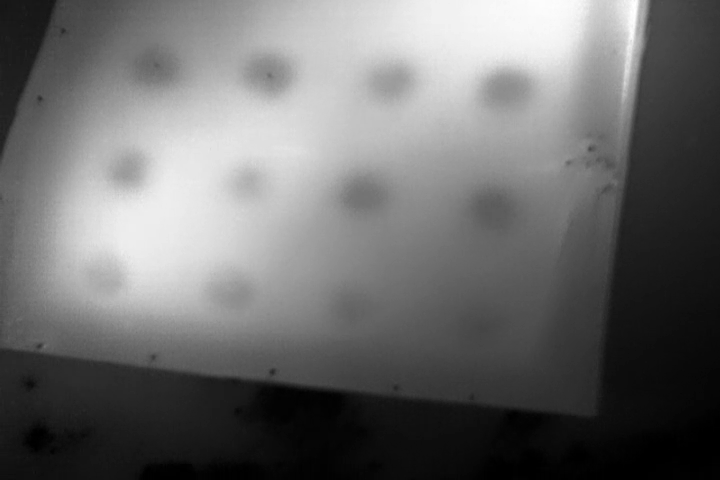

0 / 200 : 100 , 3.352632522583008
1 / 200 : 100 , 3.070014476776123
2 / 200 : 89 , 2.9487245082855225
3 / 200 : 70 , 2.9323365688323975
4 / 200 : 53 , 2.9185564517974854
5 / 200 : 49 , 2.814894437789917
6 / 200 : 37 , 2.7087223529815674
7 / 200 : 27 , 2.46197247505188
8 / 200 : 22 , 2.2007296085357666
9 / 200 : 21 , 2.0063138008117676
10 / 200 : 19 , 1.7548273801803589
11 / 200 : 19 , 1.53300940990448
12 / 200 : 18 , 1.3126718997955322
13 / 200 : 18 , 1.109279751777649
14 / 200 : 17 , 0.9318699240684509
15 / 200 : 17 , 0.7650854587554932
16 / 200 : 16 , 0.6247064471244812
17 / 200 : 15 , 0.5095318555831909
18 / 200 : 15 , 0.4204115867614746
19 / 200 : 15 , 0.3474125862121582
20 / 200 : 15 , 0.2923758327960968
21 / 200 : 15 , 0.2547560930252075
22 / 200 : 14 , 0.22209849953651428
23 / 200 : 13 , 0.19492194056510925
24 / 200 : 13 , 0.1727992296218872
25 / 200 : 13 , 0.15381023287773132
26 / 200 : 13 , 0.13918375968933105
27 / 200 : 13 , 0.1277226358652115
28 / 200 : 13 , 0.11851368099451

array([[77, 77, 77, ..., 77, 77, 77],
       [77, 14, 14, ..., 35, 77, 77],
       [77, 14, 14, ..., 35, 35, 77],
       ...,
       [77,  4,  4, ..., 55, 55, 77],
       [77,  4,  4, ..., 55, 77, 77],
       [77, 77, 77, ..., 77, 77, 77]])

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/parham/thermal-segmentor/58d044ed41934ba280b9646296c8fb65
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_noref_class_count [200] : (13, 100)
COMET INFO:     train_noref_loss [200]        : (0.03848622739315033, 3.352632522583008)
COMET INFO:     train_noref_step_time [200]   : (0.43078088760375977, 0.787179708480835)
COMET INFO:   Others:
COMET INFO:     Name         : wonjik2020_20220403-1655_Aerospace_Inspection_1 (3)
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1QsfCUN-2tOfiRXP4KIiaonw_XWhwKYo_
COMET INFO:   Parameters:
COMET INFO:     model_num_channels           : 100
COMET INFO:     model_num_conv_layers        : 6
COMET INFO:     segmentation_continuity_loss : 0.5
COMET INFO:     segmenta

In [9]:
#@title Solo experiment with no reference image 
#@markdown Run an experiment using a sample without any reference output.

import os
import logging
import numpy as np

from PIL import Image
from datetime import datetime
from comet_ml import Experiment

from IPython.display import display 

sample_file = '1 (3).png' 

# Create an experiment with your api key
now = datetime.now()

experiment.set_name('%s_%s_%s_%s' % ('wonjik2020', now.strftime('%Y%m%d-%H%M'), dataset_name, sample_file.split('.')[0]))
experiment.add_tag(dataset_name)

img = Image.open(os.path.join(img_dataset_path,sample_file))
img = img.convert('RGB')
display(img)

img = np.asarray(img)

if img is None:
    err_msg = f'{sample_file} is not valid file!'
    logging.error(err_msg)
    raise ValueError(err_msg)

state = engine.run([[img,np.zeros(img.shape)]])
display(Image.fromarray(np.uint8(state.output[1])).convert('RGB'))

experiment.end()
